In [4]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [5]:

def simulate_vasicek_short_rates_euler(r0, kappa, theta, sigma, T, dt, seed=None):
    """
    Simulates the Vasicek short rates model using the 
    Euler-Maruyama discretization. 
    
    Parameters:
    r0 (float): Initial (current) short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Annualized volatility of the short rate process.
    T (float): Number of years to simulate.
    dt (float): Time step size.
    
    Returns:
    times (np.ndarray): Time steps.
    rates (np.ndarray): Simulated short rates.
    """

    np.random.seed(seed)
    
    nd = int(T / dt)

    times = np.linspace(0, T, nd + 1)

    rates = np.zeros(nd)
    rates[0] = r0

    diffusion = sigma * np.random.normal(0, np.sqrt(dt), nd)

    for t in range(1, nd):
        dr = kappa * (theta - rates[t-1]) * dt + diffusion[t]
        rates[t] = rates[t-1] + dr
        
    return times, rates


In [6]:
def simulate_vasicek_short_rates_exact(r0, kappa, theta, sigma, T, dt, seed=None):
    """
    Simulates the Vasicek short rates model using the 
    Doob (analytical solution)
    
    Parameters:
    r0 (float): Initial (current) short rate.
    kappa (float): Speed of mean reversion.
    theta (float): Long-term mean level of the short rate.
    sigma (float): Annualized volatility of the short rate process.
    T (float): Number of years to simulate.
    dt (float): Time step size.
    
    Returns:
    times (np.ndarray): Time steps.
    rates (np.ndarray): Simulated short rates.
    """

    np.random.seed(seed)

    nd = int(T / dt)

    times = np.linspace(0, T, nd + 1)

    rates = np.zeros(nd)
    rates[0] = r0

    exp_kappa_dt = np.exp(-kappa * dt)
    variance = sigma**2 * (1 - np.exp(-2 * kappa * dt)) / (2 * kappa)
    for t in range(1, N):
        exp_rate = (theta * (1 - exp_kappa_dt) + rates[t-1] * exp_kappa_dt)
        rates[t] = np.random.normal(exp_rate, np.sqrt(variance))
    
    return times, rates


In [57]:

def vasicek_log_likelihood(params, r):
    kappa, theta, sigma = params
    r0 = r[0]
    dt = 1 / 252
    N = len(r)
    
    mean = r[:-1] + kappa * (theta - r[:-1]) * dt
    variance = sigma**2 * dt
    
    logL = np.sum(
        -0.5 * (np.log(2 * np.pi * variance)) - 
        (r[1:] - mean)**2 / (2 * variance)
    )
    
    return -logL

def calibrate_vasicek_mle(r):
    initial_params = [0.05, np.mean(r), np.std(np.diff(r)) * np.sqrt(252)]
    print(f"Initial Parameters: {initial_params}")
    bounds = [(0, None), (None, None), (1e-8, None)]
    
    result = minimize(vasicek_log_likelihood, initial_params, args=(r,), bounds=bounds, method='POWELL')
    
    kappa, theta, sigma = result.x
    return kappa, theta, sigma



In [58]:

def vasicek_moments(params, r):
    kappa, theta, sigma = params
    r0 = r[0]
    dt = 1 / 252 # Assuming daily data, dt can be changed accordingly
    N = len(r)
    
    m1 = np.mean(r[1:] - r[:-1]) - kappa * (theta - np.mean(r[:-1])) * dt
    m2 = np.mean((r[1:] - r[:-1])**2) - sigma**2 * dt
    
    return np.array([m1, m2])

def vasicek_gmm_objective(params, r):
    moments = vasicek_moments(params, r)
    return np.sum(moments**2)

def calibrate_vasicek_gmm(r):
    initial_params = [0.15, np.mean(r), 0.15]
    bounds = [(0, None), (None, None), (0, None)]
    result = minimize(vasicek_gmm_objective, initial_params, args=(r,), bounds=bounds)
    kappa, theta, sigma = result.x
    return kappa, theta, sigma


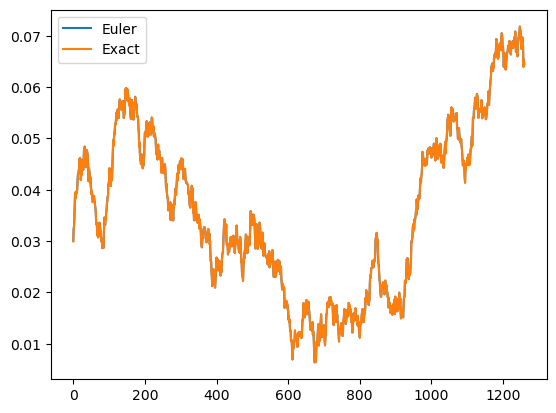

Initial Parameters: [0.05, 0.03599524865783459, 0.019536657022496004]
MLE calibrated parameters: kappa=0.41878018834576586, theta=0.052470210089552174, sigma=0.019547073705031035
GMM calibrated parameters: kappa=0.15, theta=0.03599524865783459, sigma=0.15


In [59]:

# Simulation parameters
r0 = 0.03
kappa = 0.95
theta = 0.05
sigma = 0.02
T = 5.0  # Total time in years
dt = 1/252  # Daily time steps
seed = 0

# Simulate using Euler discretization
rates_euler = simulate_vasicek_euler(r0, kappa, theta, sigma, T, dt, seed)
plt.plot(rates_euler, label='Euler')

# Simulate using exact discretization
rates_exact = simulate_vasicek_exact(r0, kappa, theta, sigma, T, dt, seed)
plt.plot(rates_exact, label='Exact')

plt.legend()
plt.show()

# Calibration parameters
market_rates = rates_exact  # Assuming market observed short rates are the simulated exact rates

# MLE Calibration
kappa_mle, theta_mle, sigma_mle = calibrate_vasicek_mle(market_rates)
print(f'MLE calibrated parameters: kappa={kappa_mle}, theta={theta_mle}, sigma={sigma_mle}')

# GMM Calibration
kappa_gmm, theta_gmm, sigma_gmm = calibrate_vasicek_gmm(market_rates)
print(f'GMM calibrated parameters: kappa={kappa_gmm}, theta={theta_gmm}, sigma={sigma_gmm}')


0.03600180844796129
Estimated kappa: 0.43443724590537597, theta: 0.036604953233323835, sigma: 0.019593899824937294


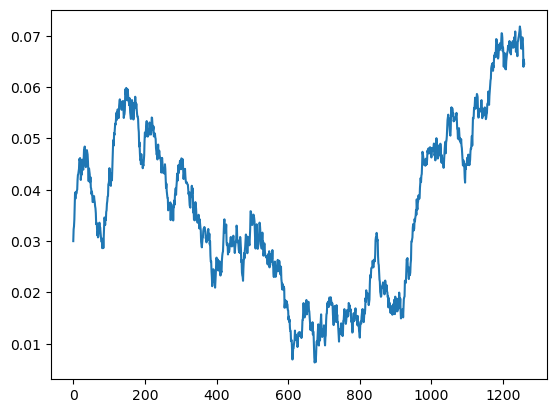

In [54]:
import numpy as np

def e_step(r, kappa, sigma):
    """
    E-Step: Estimate the expected value of the latent variable (theta).
    """
    dt = 1 / 252
    N = len(r)
    
    # Estimate theta as the weighted average of the observed data
    weights = np.exp(-kappa * np.arange(N) * dt)
    theta_est = np.sum(weights * r) / np.sum(weights)
    
    return theta_est

def m_step(r, theta_est):
    """
    M-Step: Maximize the likelihood with respect to kappa and sigma.
    """
    dt = 1 / 252
    N = len(r)
    
    # Estimate kappa by solving a linear regression
    r_diff = r[1:] - r[:-1]
    r_lag = r[:-1] - theta_est
    kappa_est = -np.sum(r_lag * r_diff) / np.sum(r_lag**2 * dt)
    
    # Estimate sigma
    residuals = r_diff - kappa_est * r_lag * dt
    sigma_est = np.sqrt(np.sum(residuals**2) / (N - 1) / dt)
    
    return kappa_est, sigma_est

def em_algorithm(r, max_iter=100, tol=1e-6):
    """
    EM algorithm for estimating the parameters of the OU process.
    """
    # Initial guesses for kappa, sigma
    kappa_est = 0.1
    sigma_est = np.std(np.diff(r)) * np.sqrt(252)
    
    for iteration in range(max_iter):
        # E-Step: Estimate theta
        theta_est = e_step(r, kappa_est, sigma_est)
        
        # M-Step: Update kappa and sigma
        kappa_new, sigma_new = m_step(r, theta_est)
        
        # Check convergence
        if np.abs(kappa_new - kappa_est) < tol and np.abs(sigma_new - sigma_est) < tol:
            break
        
        kappa_est, sigma_est = kappa_new, sigma_new
    
    return kappa_est, theta_est, sigma_est

# Example of Simulating Data for Calibration
def simulate_vasicek(kappa, theta, sigma, r0, T, dt):
    N = int(T / dt)
    r = np.zeros(N)
    r[0] = r0
    for t in range(1, N):
        dr = kappa * (theta - r[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        r[t] = r[t-1] + dr
    return r

# Simulate a Vasicek process (OU process)
np.random.seed(0)
kappa_true = 0.95
theta_true = 0.05
sigma_true = 0.02
r0 = 0.03
T = 5.0  # 1 year
dt = 1/252  # Daily steps
r_simulated = simulate_vasicek(kappa_true, theta_true, sigma_true, r0, T, dt)
print(np.mean(r_simulated))
plt.plot(r_simulated)
# Estimate the parameters using the EM algorithm
kappa_est, theta_est, sigma_est = em_algorithm(r_simulated)
print(f"Estimated kappa: {kappa_est}, theta: {theta_est}, sigma: {sigma_est}")


In [56]:
import numpy as np

def e_step_kappa(r, theta, sigma):
    """
    E-Step: Estimate the expected value of the latent variable (kappa).
    """
    dt = 1 / 252
    N = len(r)
    
    r_diff = r[1:] - r[:-1]
    r_lag = (r[:-1] - theta) * dt
    #kappa_est = -np.sum(r_lag * r_diff) / np.sum(r_lag**2 * dt) 
    kappa_est = np.mean(r_diff / -r_lag)
    
    return kappa_est

def m_step_theta_sigma(r, kappa_est):
    """
    M-Step: Maximize the likelihood with respect to theta and sigma.
    """
    dt = 1 / 252
    N = len(r)
    
    # Estimate theta as the mean of the series adjusted by kappa
    theta_est = np.sum(r[:-1] + r[1:]) / (2 * N) + (1 - np.exp(-kappa_est * dt)) * np.sum(r[:-1]) / N
    
    # Estimate sigma
    r_diff = r[1:] - r[:-1]
    residuals = r_diff - kappa_est * (theta_est - r[:-1]) * dt
    sigma_est = np.sqrt(np.sum(residuals**2) / (N - 1) / dt)
    
    return theta_est, sigma_est

def em_algorithm_kappa_latent(r, max_iter=1000, tol=1e-9):
    """
    EM algorithm for estimating the parameters of the OU process with kappa as latent.
    """
    # Initial guesses for theta, sigma
    theta_est = np.mean(r)
    sigma_est = np.std(np.diff(r)) * np.sqrt(252)
    
    for iteration in range(max_iter):
        # E-Step: Estimate kappa
        kappa_est = e_step_kappa(r, theta_est, sigma_est)
        
        # M-Step: Update theta and sigma
        theta_new, sigma_new = m_step_theta_sigma(r, kappa_est)
        
        # Check convergence
        if np.abs(theta_new - theta_est) < tol and np.abs(sigma_new - sigma_est) < tol:
            break
        
        theta_est, sigma_est = theta_new, sigma_new
        print(kappa_est, theta_est, sigma_est)
    
    return kappa_est, theta_est, sigma_est

# Example of Simulating Data for Calibration
def simulate_vasicek(kappa, theta, sigma, r0, T, dt):
    N = int(T / dt)
    r = np.zeros(N)
    r[0] = r0
    for t in range(1, N):
        dr = kappa * (theta - r[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        r[t] = r[t-1] + dr
    return r

# Simulate a Vasicek process (OU process)
np.random.seed(0)
kappa_true = 0.95
theta_true = 0.05
sigma_true = 0.02
r0 = 0.03
T = 5.0  # 1 year
dt = 1/252  # Daily steps
r_simulated = simulate_vasicek(kappa_true, theta_true, sigma_true, r0, T, dt)

# Estimate the parameters using the EM algorithm
kappa_est, theta_est, sigma_est = em_algorithm_kappa_latent(r_simulated)
print(f"Estimated kappa: {kappa_est}, theta: {theta_est}, sigma: {sigma_est}")


-259.03846602882436 -0.028576877619347664 1.086978705011922
-0.14986833466138968 0.03594290146223324 0.019582396055117586
-23.012416516424455 0.03252674517569153 0.031528275432433805
-1.9852545280949727 0.035679951219684966 0.019730835607799434
-4.756587060959975 0.035279263924462165 0.020292386980991593
3.217147537854741 0.03642033251603109 0.019785577452324763
-24.64448905776322 0.03227082101757293 0.032962967516787955
6.354353479414244 0.03685947296830494 0.02051364687492125
-3.305122523942208 0.03548967039804188 0.019948793483567075
-8.592737150032969 0.034717300351514754 0.021686386694207898
0.5060650522754171 0.03603641150516735 0.019573683362610554
13.759695270804453 0.03787463152832209 0.02399402366868844
8.15458903877667 0.037109009020618235 0.02114900833255084
85.01670863041761 0.04625887095781669 0.10516510109459047
-14.058565378773723 0.03390167945257715 0.024702849594397322
-18.363469198382788 0.033246723668909926 0.027741825661630123
-101.54176087070506 0.0181248083045451

In [10]:
def B(t, T, kappa, theta, sigma):
    tau = T - t
    return (1 - np.exp(-kappa * tau)) / kappa

def A(t, T, kappa, theta, sigma):
    tau = T - t
    return np.exp((theta - (sigma**2) / (2 * kappa**2)) * (B(t, T, kappa, theta, sigma) - tau) - (sigma**2) * (B(t, T, kappa, theta, sigma)**2) / (4 * kappa))

def zero_coupon_bond_price(r_t, kappa, theta, sigma, T, t=0):
    return A(t, T, kappa, theta, sigma) * np.exp(-B(t, T, kappa, theta, sigma) * r_t)

def zero_coupon_yield(r_t, kappa, theta, sigma, T, t=0):
    price = zero_coupon_bond_price(r_t, kappa, theta, sigma, T, t)
    return -np.log(price) / (T - t)

In [6]:

# Example usage
r_t = 0.05  # Current short rate
kappa = 0.1
theta = 0.05
sigma = 0.02
T = 1.0  # Maturity time in years

# Compute the zero-coupon bond price
price = zero_coupon_bond_price(r_t, kappa, theta, sigma, T)
print(f"Zero-coupon bond price: {price}")


Zero-coupon bond price: 0.9512882997253278


In [ ]:
yield_05 = np.asarray([zero_coupon_yield(0,  5, r_t, kappa, theta, sigma) for r_t in rates_exact[1]])
yield_10 = np.asarray([zero_coupon_yield(0, 10, r_t, kappa, theta, sigma) for r_t in rates_exact[1]])
yield_30 = np.asarray([zero_coupon_yield(0, 30, r_t, kappa, theta, sigma) for r_T in rates_exact[1]])